In [18]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from bs4 import BeautifulSoup
import requests
import time
from csv import writer
from datetime import datetime, timedelta
import emoji
# import streamlit_authenticator as stauth 
import schedule     

In [19]:
# Fungsi untuk melakukan scraping data
def scrape_data(start_date, end_date):
    bulan = {
        1: "Januari",
        2: "Februari",
        3: "Maret",
        4: "April",
        5: "Mei",
        6: "Juni",
        7: "Juli",
        8: "Agustus",
        9: "September",
        10: "Oktober",
        11: "November",
        12: "Desember"
    }
    data_list = []
    for date in pd.date_range(start_date, end_date):
        month_name_id = bulan[date.month]
        url_day = f"https://harga-emas.org/history-harga/{date.year}/{month_name_id}/{date.day}/"
        page = requests.get(url_day)
        soup = BeautifulSoup(page.content, 'html.parser')
        lists = soup.find('div', class_='col-md-8')
        row_data = [date.strftime('%Y-%m-%d')]
        index = 0
        for item in lists.findAll('tr'):
            index += 1
            if index == 21:
                base_value = item.findAll('b')
                index_core = 0
                for core in base_value:
                    index_core += 1
                    if index_core == 2:
                        value = core.text.split('+')[0].split('-')[0].split('(')[0]
                        value = value.replace('.', '').strip()
                        value = value.replace('Rp', '').strip()
                        value = value.replace('/', '').strip()
                        value = value.replace('gram', '').strip()
                        row_data.append(value)
        data_list.append(row_data)
        time.sleep(1)  # Jeda untuk mencegah terlalu banyak permintaan ke website
    return data_list

In [20]:
def save_to_csv(data_list, file_name):
    with open(file_name, 'a', newline='') as file:
        csv_writer = writer(file)
        csv_writer.writerows(data_list)

In [21]:
def scrape_dan_simpan():
    # Baca tanggal terakhir dari file CSV
    file_name = 'data/harga_emas.csv'
    df5 = pd.read_csv(file_name)
    last_date_str = df5.iloc[-1]['Tanggal']
    last_date = datetime.strptime(last_date_str, '%Y-%m-%d').date()
        
    start_date = last_date + timedelta(days=1)
    end_date = datetime.now().date()
        
    if start_date <= end_date:
        # Scraping data dan menyimpannya ke dalam file CSV
        data_list = scrape_data(start_date, end_date)
        save_to_csv(data_list, file_name)

In [22]:
# Load data
df = pd.read_csv('data/harga_emas.csv')
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['Tanggal'] = df['Tanggal'].dt.date
df.set_index('Tanggal', inplace=True)
df['Harga'] = (df['Price1'])
print(df.dtypes)
df.head(5)

Price100    int64
Price50     int64
Price25     int64
Price10     int64
Price5      int64
Price3      int64
Price2      int64
Price1      int64
Harga       int64
dtype: object


,Price100,Price50,Price25,Price10,Price5,Price3,Price2,Price1,Harga
Tanggal,,,,,,,,,
2014-01-01,48550000,24300000,12175000,4900000,2475000,1494000,1008000,524000,524000
2014-01-02,49150000,24600000,12325000,4960000,2505000,1512000,1020000,530000,530000
2014-01-03,49350000,24700000,12375000,4980000,2515000,1518000,1024000,532000,532000
2014-01-04,49350000,24700000,12375000,4980000,2515000,1518000,1024000,532000,532000
2014-01-05,49350000,24700000,12375000,4980000,2515000,1518000,1024000,532000,532000


In [23]:
# df.dropna(inplace = True)
# df.reset_index(inplace = True)
df.drop(['Price1', 'Price2', 'Price3', 'Price5', 'Price10', 'Price25', 'Price50', 'Price100'], axis=1, inplace=True)
df.head(5)

,Harga
Tanggal,
2014-01-01,524000
2014-01-02,530000
2014-01-03,532000
2014-01-04,532000
2014-01-05,532000


In [24]:
# #load data lagi
# df2 = pd.read_csv('data/harga_emas.csv')
# df2['Tanggal'] = pd.to_datetime(df2['Tanggal'])
# df2.set_index('Tanggal', inplace=True)
# print(df2.dtypes)
# df2.head(5)

In [25]:
# df.dropna(inplace = True)
# df.reset_index(inplace = True)
# df2.drop(['Price1', 'Price2', 'Price3', 'Price5', 'Price10', 'Price25', 'Price50', 'Price100'], axis=1, inplace=True)
# df.head(5)

In [26]:
data_set = df.iloc[:, 0:1] #.values
pd.set_option('display.max_columns', None)

data_set.head(5)

,Harga
Tanggal,
2014-01-01,524000
2014-01-02,530000
2014-01-03,532000
2014-01-04,532000
2014-01-05,532000


In [27]:
# Learning / Preprocessing data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.00990099]
 [0.01732673]
 [0.01980198]
 ...
 [1.        ]
 [0.98267327]
 [0.98267327]]


In [28]:
# Multiple features from data provided to the model
X = []
backcandles = 30 # Jumlah hari mundur / kebelakang
print(data_set_scaled.shape[0])
for j in range(1): # jumlah kolom = 8
  X.append([])
  for i in range(backcandles, data_set_scaled.shape[0]):
    X[j].append(data_set_scaled[i - backcandles:i, j])

X = np.moveaxis(X, [0], [2])

# -1 untuk memilih kolom terakhir
X, yi = np.array(X), np.array(data_set_scaled[backcandles:, -1])
y=np.reshape(yi,(len(yi),1))
# y = yi.reshape(-1, 1)

print(X.shape)
print(y)
print(y.shape)

4603
(4573, 30, 1)
[[0.02846535]
 [0.02846535]
 [0.02846535]
 ...
 [1.        ]
 [0.98267327]
 [0.98267327]]
(4573, 1)


In [29]:
# Split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)

X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y.shape)

3658
(3658, 30, 1)
(915, 30, 1)
(3658, 1)
(915, 1)
(4573, 1)


X_train shape: (3658, 30, 1)
X_train dtype: float64
y_train shape: (3658, 1)
y_train dtype: float64
Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.0112 - val_loss: 8.6704e-04
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 6.9000e-04 - val_loss: 8.3601e-04
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 8.0702e-04 - val_loss: 5.7420e-04
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 4.5507e-04 - val_loss: 0.0015
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 4.4540e-04 - val_loss: 4.1331e-04
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 3.4703e-04 - val_loss: 0.0019
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 4.7919e-04 - val_loss: 3.4600e-04
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 3.2083e-04 - val_loss: 6.3186e-04
Epoch 9/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 4.1646e-04 - val_loss: 3.2875e-04
Epoch 10/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/ste

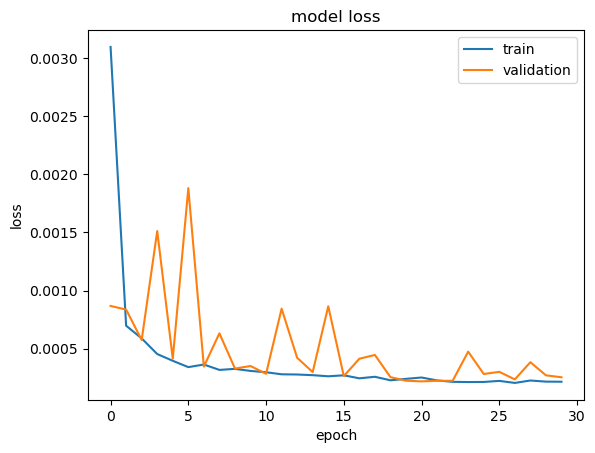

In [30]:
from keras.models import Sequential

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, TimeDistributed
import numpy as np
import matplotlib.pyplot as plt

# backcandles = 30

lstm_input = Input(shape=(backcandles, 1), name="lstm_input")
inputs = LSTM(150, name="first_layer")(lstm_input)
inputs = Dense(1, name="dense_layer")(inputs)
output = Activation('linear', name="output")(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')

print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("y_train shape:", y_train.shape)
print("y_train dtype:", y_train.dtype)

model_test = model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)

plt.plot(model_test.history['loss'])
plt.plot(model_test.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [31]:
# Prediction
y_pred = model.predict(X_test)
for i in range(10):
  print(y_pred[i], y_test[i])

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
[0.8453731] [0.85024752]
[0.8436659] [0.85024752]
[0.84187615] [0.85024752]
[0.84054613] [0.85024752]
[0.839903] [0.67574257]
[0.6577303] [0.6769802]
[0.68415546] [0.68811881]
[0.6732585] [0.68811881]
[0.6683826] [0.70792079]
[0.6904555] [0.70792079]


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE score: ", mse)

# RMSE
rmse = np.sqrt(mse)
print("RMSE score: ", rmse)

# MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE score: ", mae)

#R2
r2 = r2_score(y_test, y_pred)
print("r2_score: ", r2)

MSE score:  0.0005223059255171172
RMSE score:  0.022854013335016615
MAE score:  0.011850953771587808
r2_score:  0.9099157486030124


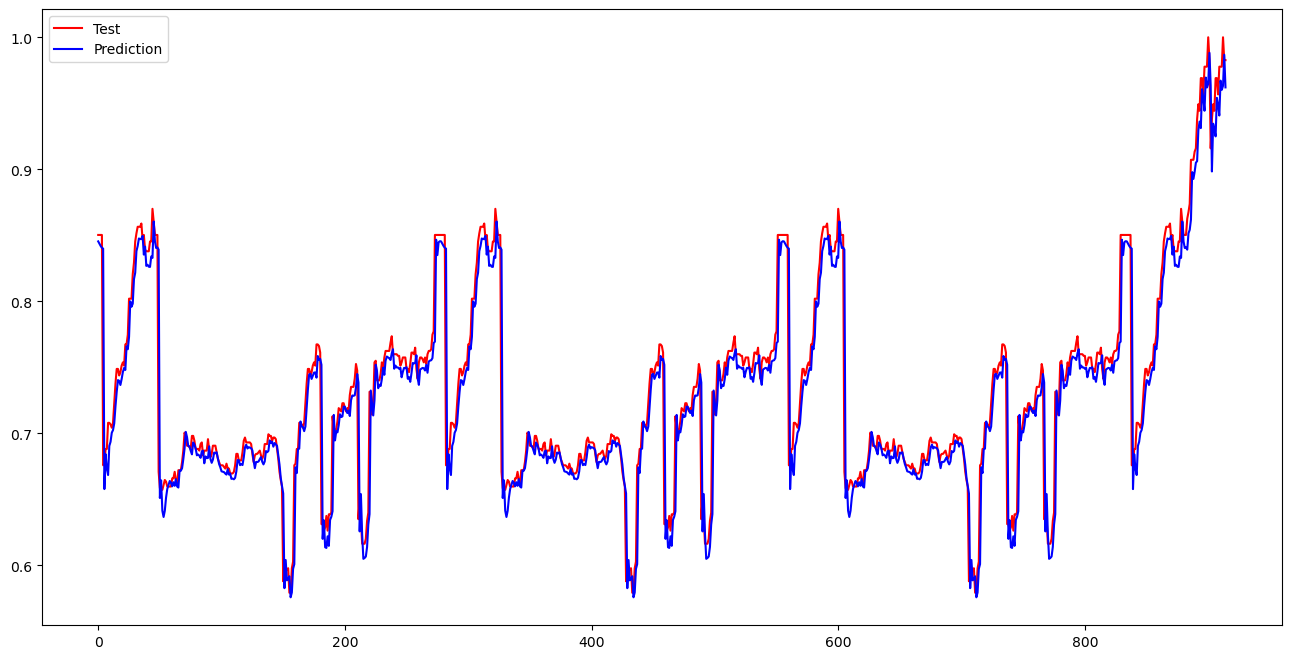

In [33]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color="red", label="Test")
plt.plot(y_pred, color="blue", label="Prediction")
plt.legend()
plt.show()

In [34]:
# Get the last backcandles days' price
last_backandles_prices = data_set_scaled[-backcandles:]

# Reshape the data to match the modul input shape
last_backandles_prices = last_backandles_prices.reshape((1, backcandles, 1))

# Predict tomorrow's price
predicted_tomorrow_price = model.predict(last_backandles_prices)

# Inverse transform the predicted price to get the actual price
predicted_tomorrow_price = sc.inverse_transform(predicted_tomorrow_price)

print("Tomorrow's price: ", predicted_tomorrow_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tomorrow's price:  1299895.4
